In [1]:
import tensorflow as tf

In [2]:
    import numpy as np 
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import cv2
    import os 
    import random
    from tqdm import tqdm
    from sklearn.model_selection import train_test_split
    import tensorflow as tf
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
    from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
    from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
    from tensorflow.keras import regularizers

In [3]:
np.random.seed(42)

In [4]:
os.listdir(r'C:\Users\Rohit\Downloads\archive (3)')

['ck', 'CK+48']

In [5]:
DATADIR = r'C:\Users\Rohit\Downloads\archive (3)\ck\CK+48'

In [6]:
CATEGORIES = os.listdir(DATADIR)
CATEGORIES


['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']

In [7]:
def load_data():
    DATADIR = r'C:\Users\Rohit\Downloads\archive (3)\ck\CK+48'
    data = []
    # loading training data
    for category in CATEGORIES:
        # create path to image of respective expression
        path = os.path.join(DATADIR, category)
        # get the classification  for each expression 
        class_num = CATEGORIES.index(category)

        for img in tqdm(os.listdir(path)):
            img_array = cv2.imread(os.path.join(path, img), 0)
            data.append([img_array, class_num])
            
    return data

In [8]:
data = load_data()

100%|███████████████████████████████████████████████████████████████████████████████| 249/249 [00:02<00:00, 101.43it/s]


In [9]:
len(data)

981

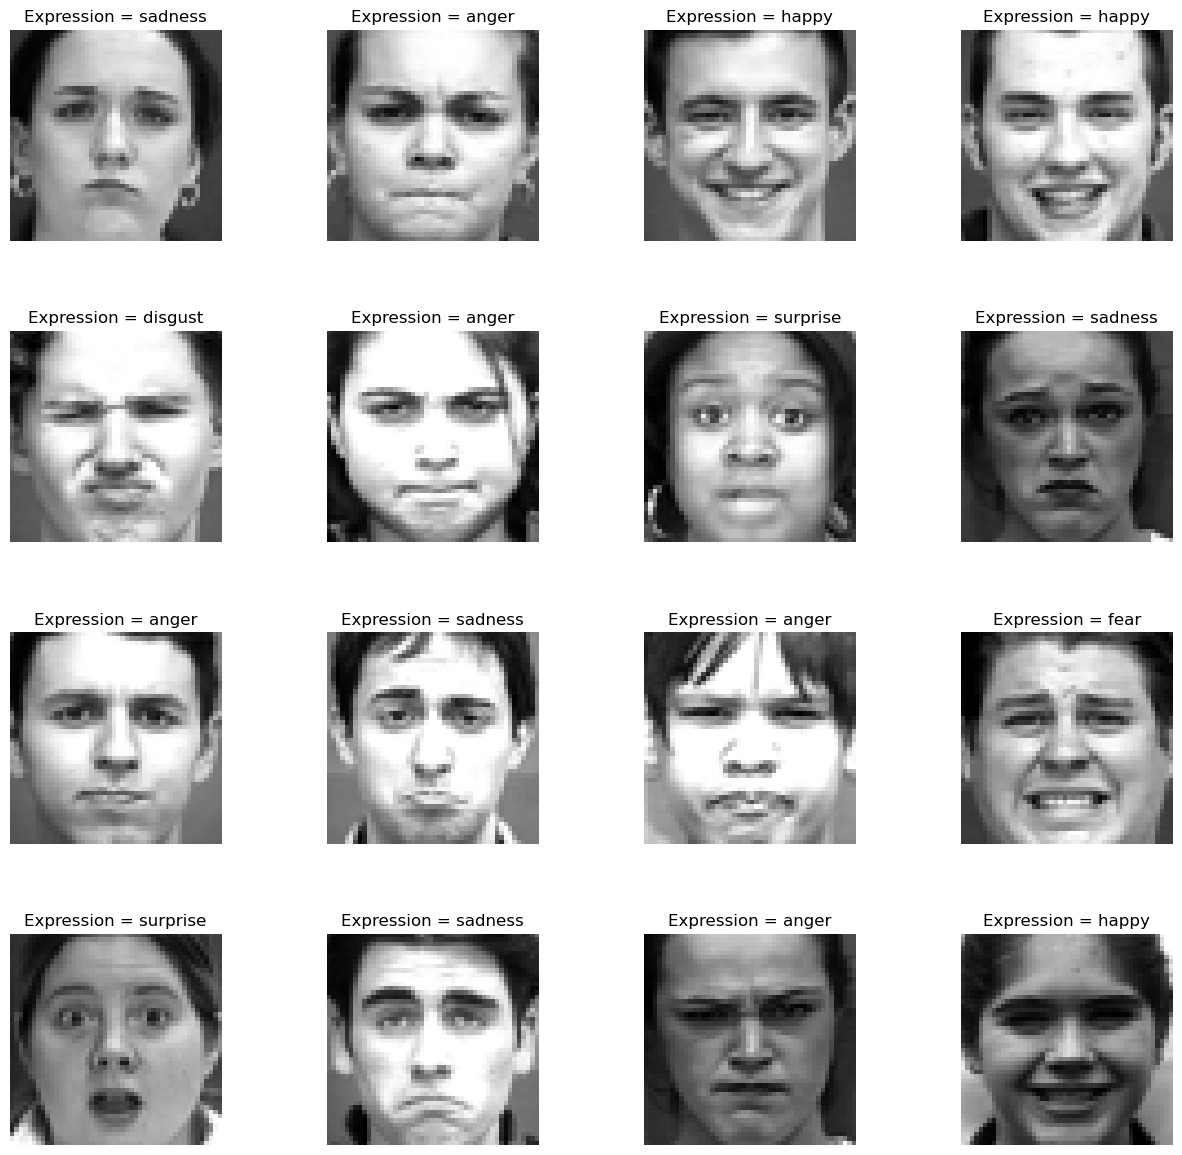

In [10]:
#Lets Visualize some images
L = 4
W = 4
fig, axes = plt.subplots(L, W, figsize = (15,15))
axes = axes.ravel()

for i in range(0, L * W):  
    sample = random.choice(data)
    axes[i].set_title("Expression = "+str(CATEGORIES[sample[1]]))
    axes[i].imshow(sample[0], cmap='gray')
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

In [11]:
#Creating training and testing data
X = np.array([ x[0] for x in data])
y = np.array([Y[1] for Y in data])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)

In [13]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("-------------------------------")
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (784, 48, 48)
y_train shape:  (784,)
-------------------------------
X_test shape:  (197, 48, 48)
y_test shape:  (197,)


In [14]:
# reshaping y_train and y_test
y_train = np.reshape(y_train, (len(y_train),1))
y_test  = np.reshape(y_test , (len(y_test ),1))

print("After reshaping")
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

After reshaping
y_train shape:  (784, 1)
y_test shape:  (197, 1)


In [15]:
X_train_Gabor  = X_train
X_test_Gabor = X_test

In [16]:
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)

print("After adding color channel")
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

After adding color channel
X_train shape:  (784, 48, 48, 1)
X_test shape:  (197, 48, 48, 1)


In [17]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [18]:
y_train[0]

array([6])

In [19]:
y_train_SVM = y_train
y_test_SVM = y_test

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [20]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [21]:
y_train.shape, y_test.shape

((784, 7), (197, 7))

In [22]:
from skimage.transform import resize
from skimage.feature import hog

C:\Users\Rohit\AppData\Local\Temp\ipykernel_12616\4222279622.py:11: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(


(-0.5, 47.5, 47.5, -0.5)

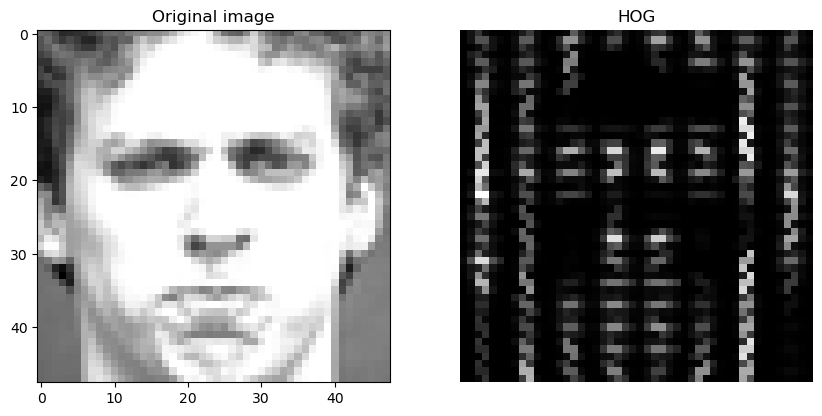

In [23]:
#How Hog looks 
plt.figure(figsize=(10, 10))


plt.subplot(1,2,1)
img = random.choice(X_train)
# first image needs to be resized before passing it to HOG descriptor
resized_img =  resize(img, (128, 64))
plt.title("Original image")
plt.imshow(img, cmap='gray')
fd, hog_image = hog(
    resized_img, 
    orientations=9, 
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2), 
    visualize=True, 
    multichannel=True
)
plt.subplot(1,2,2)
plt.title("HOG")
plt.imshow(resize(hog_image, (48, 48)), cmap='gray')
plt.axis('off')

In [24]:
#Creating Feature Vectors for training and testing
def Create_Hog_features(data):
    Feature_data = np.zeros((len(data),48,48))

    for i in range(len(data)):
        img = data[i]
        resized_img = resize(img, (128, 64))
        fd, hog_image = hog(
            resized_img, 
            orientations=9, 
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2), 
            visualize=True, 
            multichannel=True
        )
        Feature_data[i] = resize(hog_image, (48, 48))
    return Feature_data

In [25]:
Feature_X_train = Create_Hog_features(X_train)
Feature_X_train.shape

C:\Users\Rohit\AppData\Local\Temp\ipykernel_12616\1424759654.py:8: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(


(784, 48, 48)

(-0.5, 47.5, 47.5, -0.5)

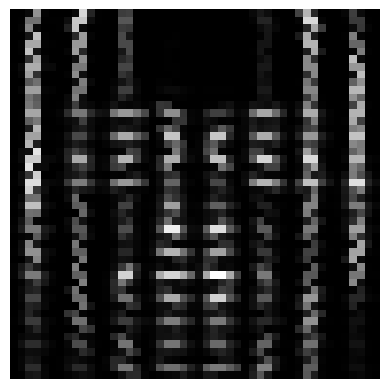

In [26]:
plt.imshow(random.choice(Feature_X_train), cmap='gray')
plt.axis('off')

In [27]:
# doing same for test data 
Feature_X_test = Create_Hog_features(X_test)

Feature_X_test.shape

C:\Users\Rohit\AppData\Local\Temp\ipykernel_12616\1424759654.py:8: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(


(197, 48, 48)

(-0.5, 47.5, 47.5, -0.5)

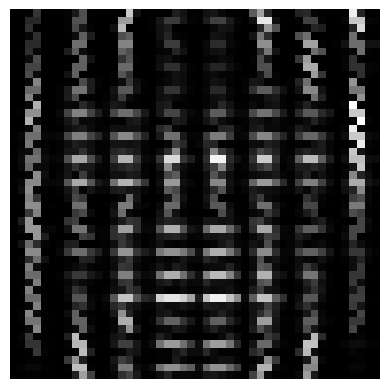

In [28]:
plt.imshow(random.choice(Feature_X_test), cmap='gray')
plt.axis('off')

In [29]:
# Again adding color channel as it got removed while converting img to hog img
X_train_HOG = np.expand_dims(Feature_X_train, axis=3)
X_test_HOG = np.expand_dims(Feature_X_test, axis=3)

print("After adding color channel")
print("X_train_HOG shape: ", X_train_HOG.shape)
print("X_test_HOG shape: ", X_test_HOG.shape)

After adding color channel
X_train_HOG shape:  (784, 48, 48, 1)
X_test_HOG shape:  (197, 48, 48, 1)


In [30]:
print("X_train_HOG shape: ", X_train_HOG.shape)
print("y_train shape: ", y_train.shape)
print("X_test_HOG shape: ", X_test_HOG.shape)
print("y_test shape: ", y_test.shape)

X_train_HOG shape:  (784, 48, 48, 1)
y_train shape:  (784, 7)
X_test_HOG shape:  (197, 48, 48, 1)
y_test shape:  (197, 7)


In [31]:
# train_datagen = ImageDataGenerator(
#     rotation_range=25, width_shift_range=0.1,
#     height_shift_range=0.1, shear_range=0.2, 
#     zoom_range=0.2,horizontal_flip=True, 
#     fill_mode="nearest"
# )

In [32]:
#Training and testing the HOG - CNN model
def create_model(input_shape=None):
    if input_shape is None :
        input_shape=(48,48,1)

    model = Sequential()
    model.add(Conv2D(6, (5, 5), input_shape=input_shape, padding='same', activation = 'relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(16, (5, 5), padding='same', activation = 'relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(7, activation = 'softmax'))
    
    return model 

In [33]:
es = EarlyStopping(
    monitor='val_accuracy', min_delta=0.0001, patience=10, verbose=2,
    mode='max', baseline=None, restore_best_weights=True
)
lr = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=5, verbose=2,
    mode='max', min_delta=1e-5, cooldown=0, min_lr=0
)

callbacks = [es, lr]

In [34]:
HOG_model = create_model()

In [35]:
HOG_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        9280      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 5, 64)         0

In [36]:
HOG_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam' )

In [37]:
HOG_history = HOG_model.fit(X_train_HOG, y_train, batch_size=8 , epochs=50, validation_data = (X_test_HOG, y_test), callbacks = [callbacks])

Epoch 1/50
98/98 [==============================] - 6s 35ms/step - loss: 1.8568 - accuracy: 0.2347 - val_loss: 1.8434 - val_accuracy: 0.2284 - lr: 0.0010
Epoch 2/50
98/98 [==============================] - 3s 26ms/step - loss: 1.8150 - accuracy: 0.2615 - val_loss: 1.8057 - val_accuracy: 0.2284 - lr: 0.0010
Epoch 3/50
98/98 [==============================] - 3s 27ms/step - loss: 1.7854 - accuracy: 0.2781 - val_loss: 1.7469 - val_accuracy: 0.3299 - lr: 0.0010
Epoch 4/50
98/98 [==============================] - 3s 27ms/step - loss: 1.6466 - accuracy: 0.3737 - val_loss: 1.5921 - val_accuracy: 0.4416 - lr: 0.0010
Epoch 5/50
98/98 [==============================] - 3s 27ms/step - loss: 1.3911 - accuracy: 0.5191 - val_loss: 1.2401 - val_accuracy: 0.5482 - lr: 0.0010
Epoch 6/50
98/98 [==============================] - 3s 27ms/step - loss: 1.1072 - accuracy: 0.6135 - val_loss: 1.0002 - val_accuracy: 0.6396 - lr: 0.0010
Epoch 7/50
98/98 [==============================] - 3s 27ms/step - loss: 0.9

In [38]:
def plot_performance(history):
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')

    plt.legend()
    plt.grid()
    plt.title('train and val loss evolution')

    plt.subplot(2, 1, 2)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')

    plt.legend()
    plt.grid()
    plt.title('train and val accuracy')

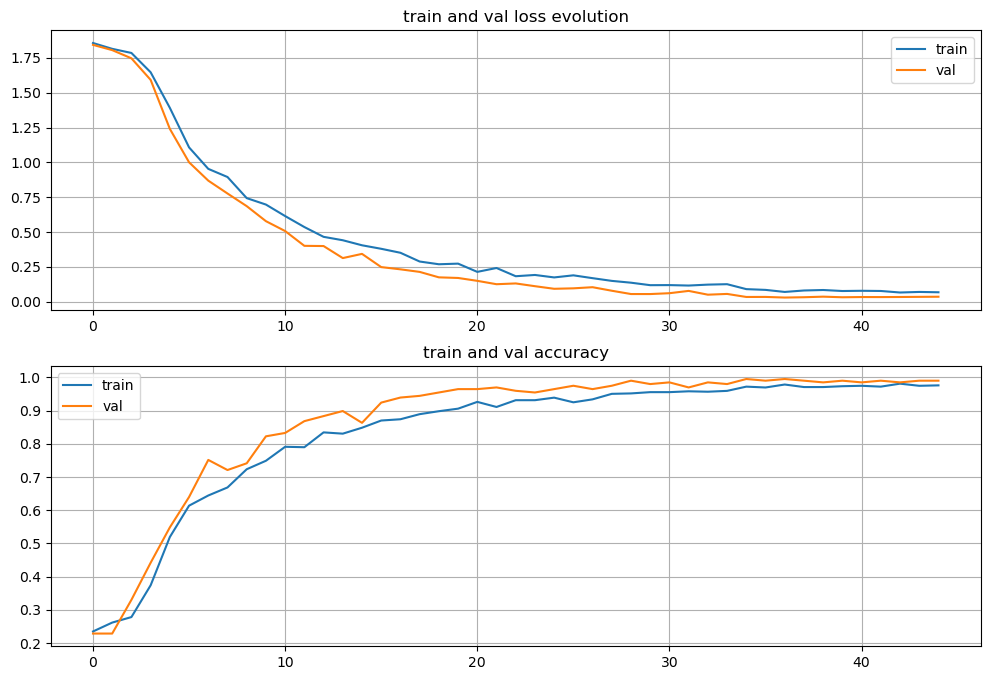

In [39]:
plot_performance(HOG_history)


In [40]:
acc = []

In [41]:
HOG_acc = HOG_model.evaluate(X_test_HOG, y_test, verbose = 0)[1]
acc.append(HOG_acc)
print("HOG Accuracy :",HOG_model.evaluate(X_test_HOG, y_test, verbose = 0)[1])

HOG Accuracy : 0.9949238300323486


In [42]:
HOG_model.save('HOG_model.h5')

In [43]:
from sklearn.svm import LinearSVC

In [44]:
Feature_X_train.shape

(784, 48, 48)

In [45]:
Feature_X_train[0].shape

(48, 48)

In [46]:
X_train_HOG_Flat = np.zeros((len(X_train), 48*48))
for i in range(len(Feature_X_train)):
    img = Feature_X_train[0]
    img = img.flatten()
    X_train_HOG_Flat[i] = img
X_train_HOG_Flat.shape

(784, 2304)

In [47]:
X_test_HOG_Flat = np.zeros((len(X_test), 48*48))
for i in range(len(Feature_X_test)):
    img = Feature_X_test[0]
    img = img.flatten()
    X_test_HOG_Flat[i] = img
X_test_HOG_Flat.shape

(197, 2304)

In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [49]:
scaler = StandardScaler()
X_train_HOG_Flat = scaler.fit_transform(X_train_HOG_Flat)

In [50]:
X_train_HOG_Flat.shape

(784, 2304)

In [51]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
param_grid={'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','poly']}
svc=svm.SVC(probability=True, verbose = True )
model=GridSearchCV(svc,param_grid)

In [52]:
y_train_SVM.shape

(784, 1)

In [53]:
a = np.squeeze(y_train_SVM)
a.shape

(784,)

In [54]:
model.fit(X_train_HOG_Flat,a)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

GridSearchCV(estimator=SVC(probability=True, verbose=True),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [0.0001, 0.001, 0.1, 1],
                         'kernel': ['rbf', 'poly']})

In [55]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test_HOG_Flat)
accuracy_score(np.squeeze(y_test_SVM),y_pred)

0.22842639593908629

In [56]:
1-0.2131979695431472

0.7868020304568528

In [57]:
#Without Feature Extraction(using cnn)
WFE_model = create_model()
WFE_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam' )

In [58]:
WFE_history = WFE_model.fit(X_train, y_train, batch_size=8 , epochs=50, validation_data = (X_test, y_test) ,callbacks = [callbacks])

Epoch 1/50
98/98 [==============================] - 5s 31ms/step - loss: 1.8433 - accuracy: 0.2615 - val_loss: 1.7778 - val_accuracy: 0.3401 - lr: 0.0010
Epoch 2/50
98/98 [==============================] - 3s 26ms/step - loss: 1.5157 - accuracy: 0.4324 - val_loss: 1.2060 - val_accuracy: 0.5381 - lr: 0.0010
Epoch 3/50
98/98 [==============================] - 3s 27ms/step - loss: 1.0262 - accuracy: 0.6110 - val_loss: 0.9401 - val_accuracy: 0.7310 - lr: 0.0010
Epoch 4/50
98/98 [==============================] - 3s 27ms/step - loss: 0.7618 - accuracy: 0.6939 - val_loss: 0.5496 - val_accuracy: 0.8071 - lr: 0.0010
Epoch 5/50
98/98 [==============================] - 3s 27ms/step - loss: 0.5576 - accuracy: 0.7934 - val_loss: 0.3909 - val_accuracy: 0.8782 - lr: 0.0010
Epoch 6/50
98/98 [==============================] - 3s 26ms/step - loss: 0.4176 - accuracy: 0.8533 - val_loss: 0.3505 - val_accuracy: 0.8832 - lr: 0.0010
Epoch 7/50
98/98 [==============================] - 3s 26ms/step - loss: 0.3

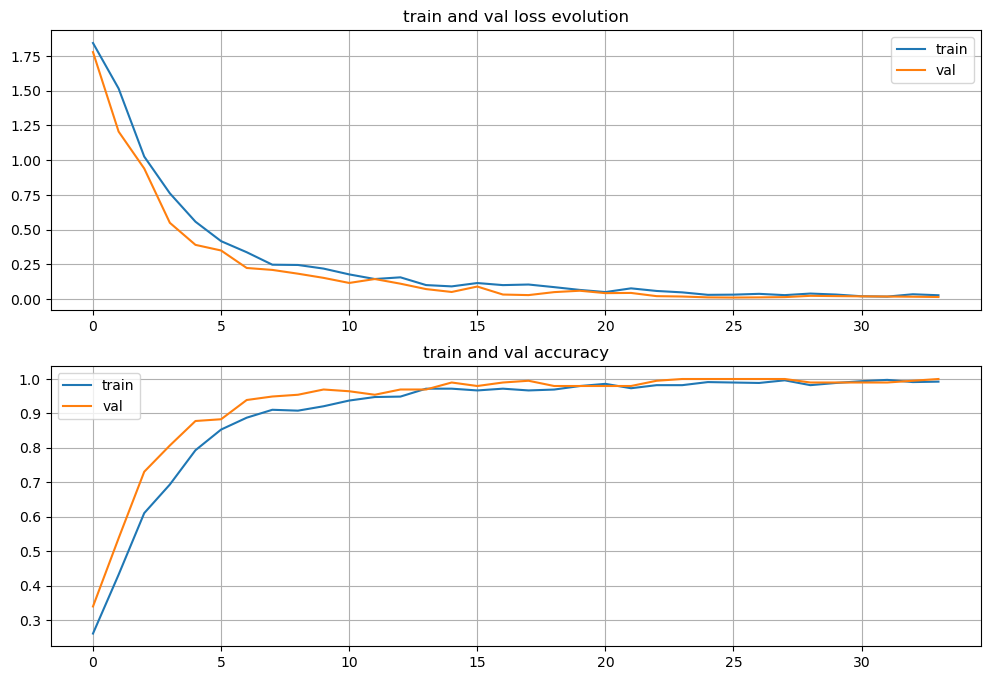

In [59]:
plot_performance(WFE_history)

In [60]:
WFE_acc = WFE_model.evaluate(X_test, y_test, verbose = 0)[1]
acc.append(WFE_acc)
print("CNN Accurecy :", WFE_acc)

CNN Accurecy : 1.0


In [61]:
#Comparing accuracies
acc

[0.9949238300323486, 1.0]